In [58]:
from math import pi, sqrt, log, ceil, floor, exp, sin
from numpy import log
import pandas as pd

def ftt_01w(tt, w, err=1e-4):
    """根据 Navarro 和 Fuss (2009) 计算 f(t|0,1,w)"""
    # tt 标准化的反应时间
    # w 起始点 w = z/a
    # err 误差

    # 需要多少项才满足误差要求 kl: k_large
    if pi * tt * err < 1:  # 检查错误阈值
        kl = sqrt(-2 * log(pi * tt * err) / (pi ** 2 * tt))  # 使用对数近似估计项数
        kl = max(kl, 1.0 / (pi * sqrt(tt)))  
    else:  # 阈值太高
        kl = 1.0 / (pi * sqrt(tt))  # 边界条件

    # 需要多少项才能满足误差要求 ks: k_small
    if 2 * sqrt(2 * pi * tt) * err < 1:  
        ks = 2 + sqrt(-2 * tt * log(2 * sqrt(2 * pi * tt) * err))  
        ks = max(ks, sqrt(tt) + 1) 
    else:  
        ks = 2  # 默认 2 项

    # 计算 f(tt|0,1,w)
    p = 0 
    if ks < kl:  # ks 更好
        K = ceil(ks)  # ks向上取整为循环中最大迭代次数
        lower = -floor((K - 1) / 2.0) # 循环上界
        upper = ceil((K - 1) / 2.0)  # 循环下界
        for k in range(lower, upper + 1):  
            p += (w + 2 * k) * exp(-(pow((w + 2 * k), 2)) / 2 / tt)  # 对p进行累加
        p /= sqrt(2 * pi * pow(tt, 3))  # 常数项

    else:  # kl 更好
        K = ceil(kl) 
        for k in range(1, K + 1):  #  1-k 循环
            p += (
                    k * exp(-(pow(k, 2)) * (pi ** 2) * tt / 2) * sin(k * pi * w)
            )  # 累加 p
        p *= pi  # 常数项

    return p


def pdf(x, k, B, a, err=1e-4):
    """根据 Navarro 和 Fuss (2009) 计算 f(x|k,B,a)""" 
    # x 反应时间 > 0
    # k 漂移系数
    # B 决策边界    前面已经有 w, 此处进行换名
    # a 起始点   a = z / B
    # err 允许的计算误差

    if x <= 0: 
        return 0

    tt = x / B ** 2  # 标准化反应时间

    p = ftt_01w(tt, w=a, err=err)  # 使用 ftt_01w 计算 p

    # 计算 f(t|v,a,w)
    xx = exp(-k * B * a - (pow(k, 2)) * x / 2.0) / (pow(B, 2))  # 转化系数
    r = p * xx  # 最终的概率密度
    return r

def ddmpdf(k, a, B, ndt, coh, correct, rt):
    """
    接受七个参数, 其中四个是 ddm 的参数
    k: 漂移系数
    a: 初始偏差, 这里表示为z和B的比例, range(0,1)
    B: 决策边界
    ndt: 非决策时间 (Ter)

    另外三个是一个trial的数据
    coh: coherence
    correct: 是否为正确的决策 (1 正确, 0 错误)
    rt: 反应时间，以秒为单位
    """
    if correct==0: #错误
        return pdf(x=rt-ndt, k=k*coh, B=B, a=a)
    elif correct==1: 
        return pdf(x=rt-ndt, k=-k*coh, B=B, a=1-a) # k 取负值, 初始点为 1 - a

import numpy as np

# 加载本地数据文件并选择 (coh, RT, correct)
data = np.genfromtxt('./experiment_data.csv', delimiter=",", names=True, dtype=None, encoding='utf-8')

data = np.column_stack((data['trial_id'], data['RT'], data['correct']))

# 负对数似然函数
def negloglikeli(params):
    '''
    <params包含的参数>: 漂移系数, 决策边界, 初始偏差, 非决策时间
    '''
    k = params[0]  
    B = params[1] 
    a = params[2] 
    ndt = params[3] 

    nTrial = data.shape[0] # 试次数量
    pp = np.empty(nTrial)  # 存储每个试次的概率密度值
    for i in range(nTrial): 
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])  

    pp = 0.999 * pp + np.finfo(np.float32).eps # 避免概率为0
    return -np.log(pp).sum()  # 累加, 注意返回负值

from scipy.optimize import minimize
res = minimize(fun=negloglikeli, x0=(0.5, 1, 0.5, 0.4), bounds=((0, 10), (0, 5), (0, 1), (0, 1))) # 使用 scipy.optimize.minimize 函数进行参数优化

print('拟合的漂移系数为', res.x[0])
print('拟合的决策边界为', res.x[1])
print('拟合的起始偏差为', res.x[2])
print('拟合的非决策时间为', res.x[3])


拟合的漂移系数为 0.3564287173577588
拟合的决策边界为 2.1438578314484604
拟合的起始偏差为 0.4116493640506867
拟合的非决策时间为 0.17716513356885527


C:\Users\26099\AppData\Local\Temp\ipykernel_20732\83931091.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  tt = x / B ** 2  # 标准化反应时间
C:\Users\26099\AppData\Local\Temp\ipykernel_20732\83931091.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  xx = exp(-k * B * a - (pow(k, 2)) * x / 2.0) / (pow(B, 2))  # 转化系数
C:\Users\26099\AppData\Local\Temp\ipykernel_20732\83931091.py:63: RuntimeWarning: invalid value encountered in scalar multiply
  r = p * xx  # 最终的概率密度


Mean RT (Actual): 0.5995 seconds
Mean RT (Simulated): 4.6872 seconds
Accuracy (Actual): 0.8900
Accuracy (Simulated): 0.8900


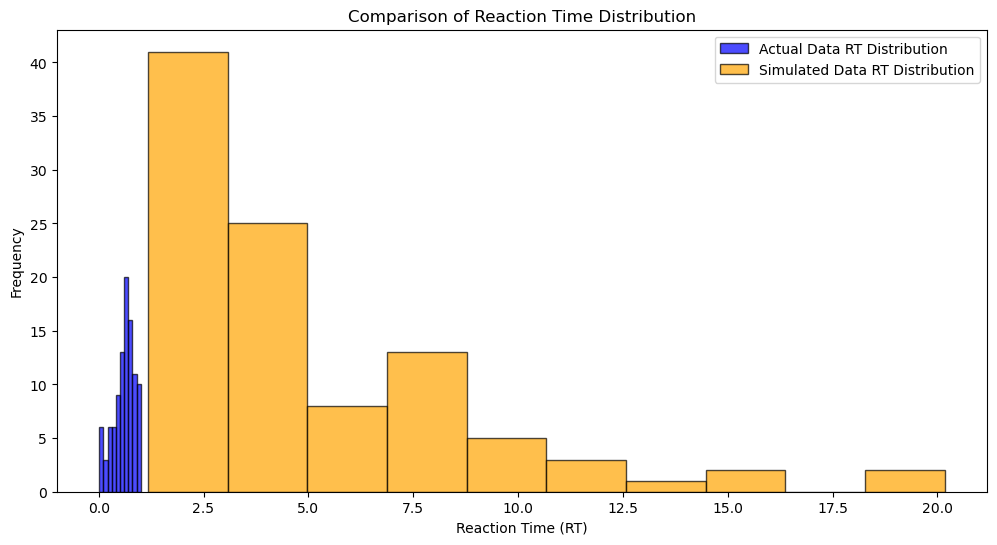

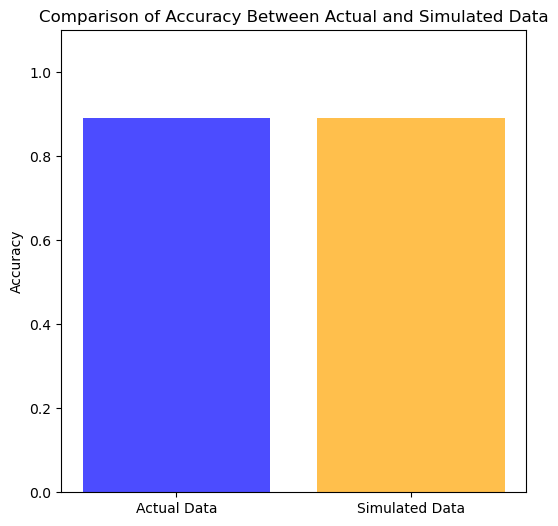

In [64]:
import matplotlib.pyplot as plt

def simulate_ddm_with_coherence(n_trials, B, a, ndt):
    coherence_levels = [0.128, 0.512, 0.768]  # coherence levels
    simulated_data = []

    for _ in range(n_trials):
        coherence = np.random.choice(coherence_levels)
        k = coherence * 0.8 # Driftrate
        
        # Init point
        x = a * B  
        time = 0
        
        # diffusion process
        while abs(x) < B:
            drift = k + np.random.normal(0, 1)  # 加噪
            x += drift  
            time += 1  
        
        # 决策
        correct = 1 if x >= B else 0  # B上边界  0下边界
        rt = time + ndt  # 总RT
        simulated_data.append((coherence, rt, correct))
    
    return np.array(simulated_data)

# 使用拟合得到的参数生成
fit_params = {
    'B': res.x[1],  
    'a': res.x[2],  
    'ndt': res.x[3] 
}
n_simulation = data.shape[0]  # 数量相同
simulated_data = simulate_ddm_with_coherence(n_simulation, **fit_params)
actual_rt = data[:, 1]  
actual_correct = data[:, 2] 
actual_accuracy = actual_correct.mean()  

simulated_coherence = simulated_data[:, 0]
simulated_rt = simulated_data[:, 1]
simulated_correct = simulated_data[:, 2]
simulated_accuracy = simulated_correct.mean()

print(f"Mean RT (Actual): {actual_rt.mean():.4f} seconds")
print(f"Mean RT (Simulated): {simulated_rt.mean():.4f} seconds")
print(f"Accuracy (Actual): {actual_accuracy:.4f}")
print(f"Accuracy (Simulated): {simulated_accuracy:.4f}")

# RT 分布对比
plt.figure(figsize=(12, 6))
plt.hist(actual_rt, bins=10, alpha=0.7, label="Actual Data RT Distribution", color="blue", edgecolor="black")
plt.hist(simulated_rt, bins=10, alpha=0.7, label="Simulated Data RT Distribution", color="orange", edgecolor="black")
plt.xlabel("Reaction Time (RT)")
plt.ylabel("Frequency")
plt.title("Comparison of Reaction Time Distribution")
plt.legend()
plt.show()

# acc 对比
plt.figure(figsize=(6, 6))
accuracy_labels = ["Actual Data", "Simulated Data"]
accuracy_values = [actual_accuracy, simulated_accuracy]
plt.bar(accuracy_labels, accuracy_values, color=["blue", "orange"], alpha=0.7)
plt.ylim(0, 1.1)
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy Between Actual and Simulated Data")
plt.show()
